# Test2Wire2 Conductance

- 22a Plot a run vs time


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as norm
from glob import glob
%matplotlib inline

In [2]:
from math import log10
def eng_str(x, u=0, n=1):
    """Print formatted value and its uncertainty in engineering format"""
    y = abs(x)
    exponent = int(log10(y))
    engr_exponent = exponent - exponent%3
    z = y/10**engr_exponent
    sign = '-' if x < 0 else ''
    fmt = "{z:.%df}" % (n)
    xStr = sign+fmt.format(z=z)
    
    # uncertainty
    yU = abs(u)
    zU = yU/10**engr_exponent
    fmtU = "{zU:.%df}" % (n)
    if engr_exponent != 0:
        uStr = " ± "+fmtU.format(zU=zU)+'e'+str(engr_exponent)
    else:
        uStr = " ± "+fmtU.format(zU=zU)
    return xStr + uStr

print(eng_str(123456, 3456, n=1))

123.5 ± 3.5e3


In [3]:
files = glob("../Data/*.csv")
files.sort()
for (i,f) in enumerate(files):
    print(f"{i}: {f}")
iFile = int(input("Enter file number: "))
dataFile = files[iFile]
plotFileFmt = "../Figures/" + dataFile[dataFile.find("2022"):dataFile.find(".csv")] + r"-%02d.png"
iPlot = 0
print(f"Opening {dataFile}")
data = np.genfromtxt(dataFile, delimiter=',', comments='#')
print(f"shape of data is {data.shape}")
print(f"Next plot file is {plotFileFmt % iPlot}")

# Now get board_id
with open(dataFile, 'r') as fp:
    line = fp.readline().strip()
    boardID = line[line.find("=")+2:]
print(f"boardID = {boardID}")

with open(dataFile, 'r') as fp:
    line = fp.readline().strip()
    while line:
        if line[0] == '#':
            print(line)
        line = fp.readline().strip()

nPoints = data.shape[0]
if data.shape[1] == 4:
    t = data[:,0] - data[0,0]
    R = data[:,1]
    uncR = data[:,2]
    TC = data[:,3]
else:
    print(f"Need 4 columns of data!, but you have {data.shape[0]}")


0: ../Data/2022-04-28-1546-DAC.csv
1: ../Data/2022-05-06-1243.csv
2: ../Data/2022-05-19-1450.csv
3: ../Data/2022-05-20-1000.csv
4: ../Data/2022-05-20-1458.csv
5: ../Data/2022-05-24-1234-2W.csv
6: ../Data/2022-05-24-1700-2W.csv
7: ../Data/2022-05-24-2102-RvsT.csv
Enter file number: 7
Opening ../Data/2022-05-24-2102-RvsT.csv
shape of data is (3170, 4)
Next plot file is ../Figures/2022-05-24-2102-RvsT-00.png
boardID = lolin_s2_mini
# board_id = lolin_s2_mini
# dacPin: board.IO18, dToV: 5.03547e-05
# v0Pin: board.IO5, v1Pin: board.IO7
# nAvg: 10, tADC: 0.001, loopTime:2
# 69 Ohm resistor
# 12 good points


In [4]:
pass

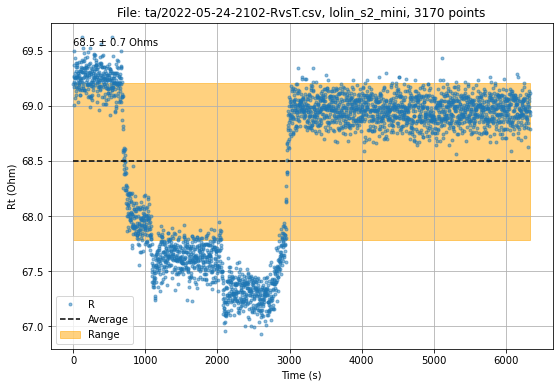

In [5]:
RAvg = R.mean()
RStd = R.std()

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(t, R, '.', label="R", alpha=0.5)
ax.plot((min(t),max(t)), 2*[RAvg], 'k--', label="Average",)
ax.fill_between((min(t),max(t)), 2*[RAvg+RStd], 2*[RAvg-RStd], color="orange", alpha=0.5, label="Range")
ax.set_title(f"File: {dataFile[5:]}, {boardID}, {nPoints} points")
ax.grid()
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Rt (Ohm)")
ax.text(min(t), max(R), eng_str(RAvg, RStd, n=1)+" Ohms", va='top')
iPlot = 0
fig.savefig(plotFileFmt % iPlot, dpi=150)
iPlot += 1


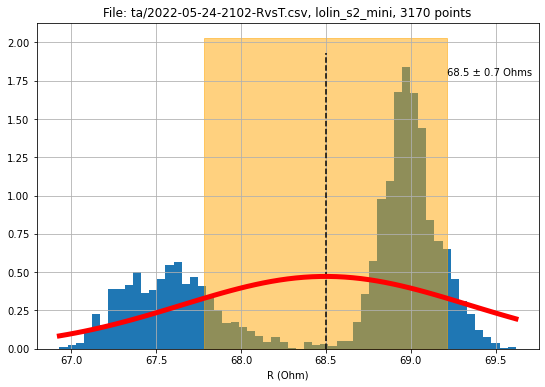

In [6]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
out = ax.hist(R, bins=int(np.sqrt(data.shape[0])), density=True)
ax.plot(2*[RAvg], (0,ax.get_ylim()[1]), 'k--', label="Average")

plt.plot(out[1], norm.pdf(out[1], RAvg, RStd), 'r-', lw=5)

ax.fill_betweenx(ax.get_ylim(), [RAvg+RStd], 2*[RAvg-RStd], color="orange", alpha=0.5)

ax.set_title(f"File: {dataFile[5:]}, {boardID}, {nPoints} points")
ax.grid()
ax.set_xlabel("R (Ohm)")
ax.text(RAvg+RStd, max(out[0]), eng_str(RAvg, RStd, n=1)+" Ohms", va='top')
iPlot = 1
fig.savefig(plotFileFmt % iPlot, dpi=150)
iPlot += 1


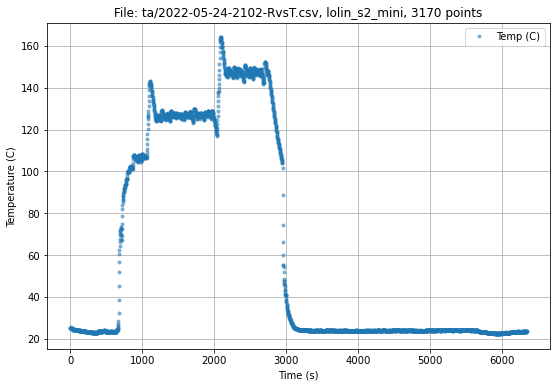

In [7]:

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(t, TC, '.', label="Temp (C)", alpha=0.5)
#ax.plot((min(t),max(t)), 2*[RAvg], 'k--', label="Average",)
#ax.fill_between((min(t),max(t)), 2*[RAvg+RStd], 2*[RAvg-RStd], color="orange", alpha=1, label="Range")
ax.set_title(f"File: {dataFile[5:]}, {boardID}, {nPoints} points")
ax.grid()
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (C)")
#ax.text(min(t), max(R), eng_str(RAvg, RStd, n=1)+" Ohms", va='top')
iPlot = 2
fig.savefig(plotFileFmt % iPlot, dpi=150)
iPlot += 1


-199.2 ± 0.8 Ohms/C


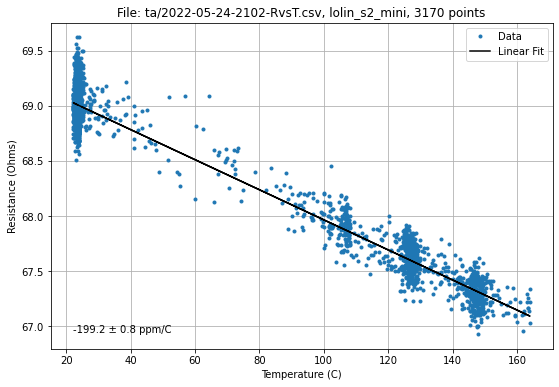

In [8]:
out = np.polyfit(TC, R, 1, rcond=None, full=False, w=uncR, cov=True)

(m, b) = out[0]
covMB = out[1]
((cmm, cmb),(cbm,cbb)) = out[1]

tempCoef = 1e6 * m / R.mean()
tempCoefUnc = 1e6 * np.sqrt(cmm) / R.mean()
print(eng_str(tempCoef, tempCoefUnc, n=1)+" Ohms/C")

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(TC, R, '.', label="Data")
ax.plot(TC, b + m * TC, 'k-', label="Linear Fit",)
#ax.fill_between((min(t),max(t)), 2*[RAvg+RStd], 2*[RAvg-RStd], color="orange", alpha=1, label="Range")
ax.set_title(f"File: {dataFile[5:]}, {boardID}, {nPoints} points")
ax.grid()
ax.legend()
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Resistance (Ohms)")
ax.text(min(TC), min(R), eng_str(tempCoef, tempCoefUnc, n=1)+" ppm/C", va='bottom')
iPlot = 3
fig.savefig(plotFileFmt % iPlot, dpi=150)
iPlot += 1


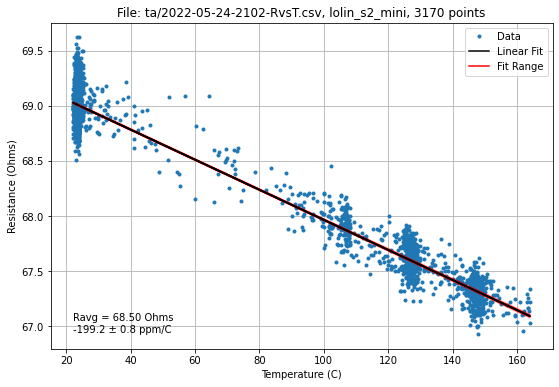

In [9]:
nRand = 100
rv = norm([m, b], covMB)
dist = rv.rvs(nRand)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(TC, R, '.', label="Data")
ax.plot(TC, b + m * TC, 'k-', label="Linear Fit")

ax.plot(TC, b + m * TC, 'r-', alpha=1, label="Fit Range")
for (mr, br) in dist:
    ax.plot(TC, br + mr * TC, 'r-', alpha=5/nRand)
# Replot to be on top
ax.plot(TC, b + m * TC, 'k-')

#ax.fill_between((min(t),max(t)), 2*[RAvg+RStd], 2*[RAvg-RStd], color="orange", alpha=1, label="Range")
ax.set_title(f"File: {dataFile[5:]}, {boardID}, {nPoints} points")
ax.grid()
ax.legend()
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Resistance (Ohms)")
ax.text(min(TC), min(R), f"Ravg = {R.mean():.2f} Ohms\n{eng_str(tempCoef, tempCoefUnc, n=1)} ppm/C", va='bottom')
iPlot = 4
fig.savefig(plotFileFmt % iPlot, dpi=150)
iPlot += 1
